# Comparaison de la régularisation L1, L2 et SPOQ

Nous utilisons le dataset digits de scikit-learn. 
Le but est d'entraîner trois régressions logistiques, régularisées chacune par une pénalité différente, puis de comparer les résultats obtenus

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tqdm import tqdm

In [2]:
def Fcost(weights, alpha=7e-7, beta=3e-2, mu=2e-6, p=0.75, q=2):
    """
    Fonction de coût SPOQ, avec les valeurs par défaut proposées dans le papier
    """
    lp = (torch.sum((weights**2 + alpha**2)**(p/2)) - alpha**p)**(1/q)
    lq = (mu**q + torch.sum(torch.abs(weights)**q))**(1/q)
    fcost = torch.log(((lp**p + beta**p)**(1/q)) / lq)
    return fcost

In [ ]:
# hyperparameters
input_size = 64 # dimension de X
num_classes = 2
num_epochs = 10000 # Nombre maximal d'epochs
learning_rate = 0.1 

X,y = load_digits(return_X_y=True)

# On transforme le dataset pour avoir un problème binaire
y = (y > 4).astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class LogisticRegression(nn.Module):
    """
    Régression logistique implémentée en PyTorch, à entraîner avec un cross-entropy loss
    """
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    def forward(self, x):
        out = self.linear(x)
        return out

def train(X_train, y_train, lambda_penalty, penalty):
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).long()
    
    optimizer.zero_grad()
    outputs = model(inputs)
    
    loss = criterion(outputs, targets)
    if penalty=="l1":
      pen = torch.norm(model.linear.weight, p=1)
    elif penalty=="l2":
      pen = torch.norm(model.linear.weight, p=2)
    elif penalty=="spoq":
      pen = Fcost(model.linear.weight)
    else:
      pen = 0
    loss += lambda_penalty*pen
    loss.backward()
    optimizer.step()
    
    return loss.item()

def valid(X_test, y_test):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).long()

    outputs = model(inputs)
    val_loss = criterion(outputs, targets)

       
    # 精度を求める
    _, predicted = torch.max(outputs, 1)

    f1 = f1_score(y_test, predicted)
    correct = (predicted == targets).sum()
    val_acc = correct.float() / targets.size(0)

    return val_loss.item(), 100*val_acc.item(), 100*f1


# On utilise une cross-entropy loss
criterion = nn.CrossEntropyLoss()

# Dictionnaires pour stocker les résultats
loss_dict = {}
val_loss_dict = {}
val_acc_dict = {}
sparsity_dict = {}
f1_dict = {}

# Dictionnaire qui fixe les intervalles lambda correspondant à chaque loss
lambda_dict = {
    "l1": np.geomspace(1e-4,0.2, 30),
    "spoq": np.geomspace(1e-2, 5, 30),
    "l2": np.geomspace(1e-3, 1, 30)
}

# Liste des pénalités pour lesquelles on veut calculer les résultats
penalties = ["l2", "l1", "spoq"]

for penalty in penalties: 
  # Liste des résultats, pour une pénalité donnée
  loss_list = []
  val_loss_list = []
  val_acc_list = []
  sparsity_list = []
  f1_list = []

  for lambda_pen in tqdm(lambda_dict[penalty]):

    model = LogisticRegression(input_size, num_classes)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # compteur pour arreter l'entrainement s'il n'y a plus suffisamment d'amélioration d'une epoch à la suivante
    no_improvement = 0
    loss=np.inf
    for epoch in range(num_epochs):
        perm = np.arange(X_train.shape[0])
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
        
        old_loss = loss
        loss = train(X_train, y_train, lambda_pen, penalty)
        
        val_loss, val_acc, f1 = valid(X_test, y_test)

        # Un poids est considéré nul si inférieur à un seuil
        # C'est nécessaire, car avec une descente de gradient classique, les poids ne seront jamais parfaitement nuls
        sparsity = 100*(torch.sum(torch.abs(model.linear.weight)<1e-3)/torch.numel(model.linear.weight)).item()
        if abs(loss-old_loss)<1e-5:
          no_improvement+=1
        else: 
          no_improvement=0
        if no_improvement>=5:
          break
    # Ajout des scores dans la liste
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    sparsity_list.append(sparsity)
    f1_list.append(f1)
    
  # Ajout de la liste des scores dans le dictionnaire
  loss_dict[penalty] = loss_list
  val_loss_dict[penalty] = val_loss_list
  val_acc_dict[penalty] = val_acc_list
  sparsity_dict[penalty] = sparsity_list
  f1_dict[penalty] = f1_list

100%|██████████| 30/30 [01:24<00:00,  2.81s/it]


## Affichage des résultats

In [ ]:
import seaborn as sns

In [ ]:
# On crée une variable data pour faciliter l'affichage avec seaborn

data = {
    "sparsity": [sparsity_dict[pen][i] for pen in penalties for i in range(len(sparsity_dict[pen]))],
    "f1_score":[f1_dict[pen][i] for pen in penalties for i in range(len(sparsity_dict[pen]))],
    "penalty":[pen for pen in penalties for i in range(len(sparsity_dict[pen]))]
}

In [ ]:
# Comme le temps de calcul est long, on a écrit en dur les résultats que nous avons obtenus

data = {'f1_score': [89.44723618090453,
  89.29765886287625,
  89.44723618090453,
  88.92617449664428,
  89.29765886287625,
  89.29765886287625,
  89.59731543624162,
  88.92617449664428,
  89.11222780569514,
  89.29765886287625,
  89.11222780569514,
  88.77721943048576,
  89.11222780569514,
  88.62876254180601,
  89.33333333333333,
  88.40336134453781,
  88.21548821548821,
  87.7966101694915,
  86.91275167785236,
  87.39495798319328,
  87.58389261744966,
  87.05882352941175,
  86.57718120805369,
  86.09715242881073,
  85.6175972927242,
  84.94077834179356,
  84.40677966101696,
  74.70288624787776,
  75.61837455830388,
  74.24749163879598,
  89.44723618090453,
  89.26174496644296,
  89.07563025210085,
  89.26174496644296,
  90.0,
  89.81636060100166,
  89.81636060100166,
  89.70099667774086,
  89.93288590604027,
  89.74789915966387,
  89.96655518394648,
  89.96655518394648,
  90.11725293132329,
  90.3010033444816,
  89.59731543624162,
  90.45226130653265,
  90.11725293132329,
  90.33333333333333,
  90.63545150501672,
  89.96655518394648,
  89.66666666666667,
  89.96655518394648,
  89.73509933774834,
  88.2943143812709,
  90.15025041736227,
  88.33333333333333,
  89.40397350993378,
  85.37414965986395,
  87.14524207011685,
  86.34064080944351,
  89.11222780569514,
  89.41176470588236,
  89.26174496644296,
  89.22558922558925,
  89.44723618090453,
  89.63210702341136,
  89.41176470588236,
  89.11222780569514,
  89.44723618090453,
  89.44723618090453,
  89.26174496644296,
  89.26174496644296,
  88.96321070234113,
  89.11222780569514,
  89.59731543624162,
  88.92617449664428,
  88.73949579831931,
  88.88888888888889,
  88.663282571912,
  88.3248730964467,
  88.21548821548821,
  88.06722689075632,
  87.49999999999999,
  87.07482993197279,
  86.54173764906304,
  85.71428571428572,
  84.55008488964347,
  83.10810810810811,
  73.92857142857143,
  59.375],
 'penalty': ['l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'l1',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'spoq',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2',
  'l2'],
 'sparsity': [3.125,
  1.5625,
  5.46875,
  0.78125,
  3.90625,
  3.125,
  3.90625,
  9.375,
  4.6875,
  11.71875,
  16.40625,
  18.75,
  21.09375,
  28.90625,
  35.15625,
  42.96875,
  44.53125,
  44.53125,
  46.09375,
  42.96875,
  29.6875,
  28.90625,
  26.5625,
  29.6875,
  20.3125,
  14.0625,
  7.8125,
  7.03125,
  5.46875,
  3.125,
  3.90625,
  4.6875,
  3.125,
  3.125,
  6.25,
  7.8125,
  9.375,
  14.84375,
  14.0625,
  17.1875,
  23.4375,
  28.90625,
  32.8125,
  39.0625,
  31.25,
  35.9375,
  32.03125,
  40.625,
  31.25,
  37.5,
  30.46875,
  35.15625,
  39.0625,
  29.6875,
  30.46875,
  32.8125,
  25.0,
  27.34375,
  35.15625,
  26.5625,
  0.78125,
  0.0,
  0.0,
  0.0,
  0.78125,
  0.78125,
  0.0,
  2.34375,
  0.0,
  0.0,
  0.78125,
  0.78125,
  0.78125,
  0.0,
  0.0,
  0.78125,
  0.0,
  0.78125,
  1.5625,
  2.34375,
  1.5625,
  3.125,
  0.78125,
  1.5625,
  2.34375,
  10.15625,
  7.8125,
  14.0625,
  28.125,
  21.875]}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


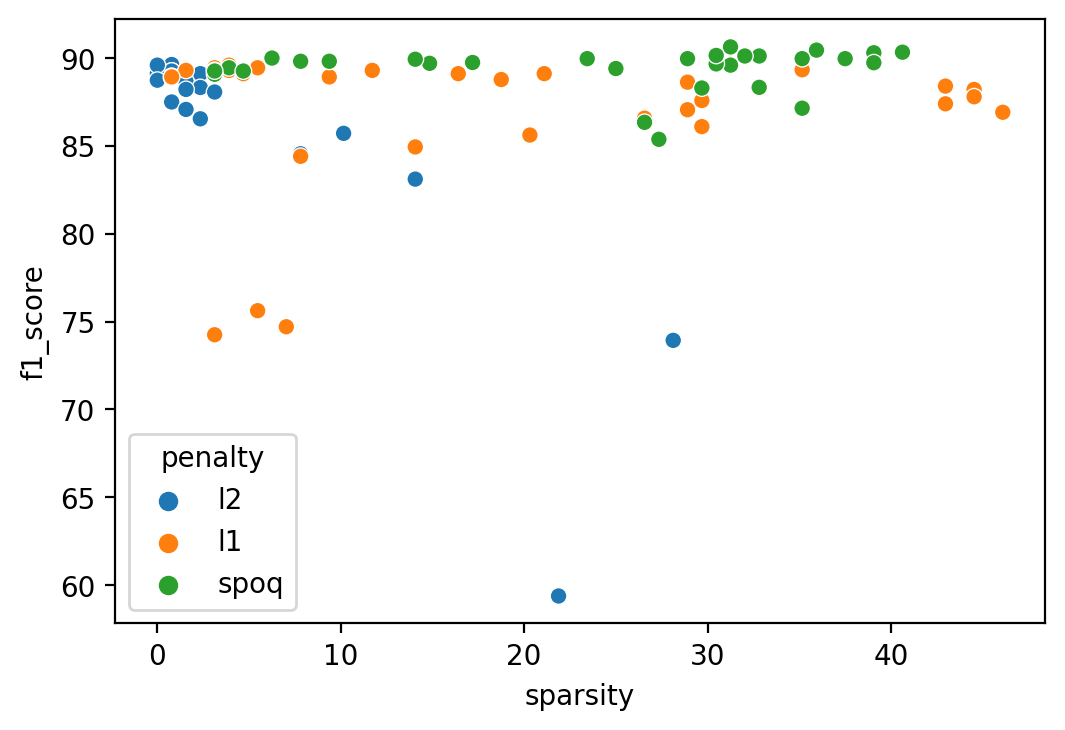

In [ ]:
# Affichage du score F1 selon la parcimonie
plt.figure(dpi=200)
sns.scatterplot("sparsity", "f1_score", hue="penalty", data=data)